In [50]:
import kagglehub

path = kagglehub.dataset_download("snap/amazon-fine-food-reviews")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/snap/amazon-fine-food-reviews/versions/2


In [51]:
import pandas as pd

df = pd.read_csv(path + "/Reviews.csv")

unique_product_ids = df['ProductId'].nunique()
total_rows = df.shape[0]

print("Number of unique ProductIds:", unique_product_ids)
print("Total number of rows:", total_rows)

Number of unique ProductIds: 74258
Total number of rows: 568454


In [52]:
product_reviews = df.groupby('ProductId').size().reset_index(name='ReviewCount')

product_reviews_sorted = product_reviews.sort_values('ReviewCount', ascending=False)

top_1000_products = product_reviews_sorted.head(1000)

top_1000_products_with_names = pd.merge(top_1000_products, df[['ProductId']], on='ProductId')

In [53]:
import pandas as pd
import requests
import json

titles = []
categories = []

for index, row in top_1000_products.iterrows():
    product_id = row['ProductId']

    params = {
        'api_key': process.env.ASIN_API_KEY,
        'amazon_domain': 'amazon.com',
        'asin': product_id,
        'type': 'product'
    }
    api_result = requests.get('https://api.asindataapi.com/request', params)

    if api_result.status_code == 200:
        product_data = api_result.json()
        if 'product' in product_data:
            if 'title' in product_data['product']:
                title = product_data['product']['title']
            else:
                title = 'N/A'

            if 'categories_flat' in product_data['product']:
                category = product_data['product']['categories_flat']
            else:
                category = 'N/A'

        else:
            title = 'N/A'
            category = 'N/A'
    else:
        title = 'N/A'
        category = 'N/A'

    titles.append(title)
    categories.append(category)

top_1000_products['Title'] = titles
top_1000_products['Category'] = categories

top_1000_products.to_csv('top_1000_products.csv', index=False)

KeyboardInterrupt: 

In [54]:
new_df = pd.read_csv("top_1000_products.csv")

new_df = new_df[new_df['Title'] != 'N/A']

new_df['Category'] = new_df['Category'].str.split('>', n=1).str[0]

new_df = new_df.groupby(['Title', 'Category'])['ProductId'].apply(list).reset_index()

new_df['ProductId'] = new_df['ProductId'].apply(lambda x: ast.literal_eval(x)[0] if isinstance(x, str) else x[0])


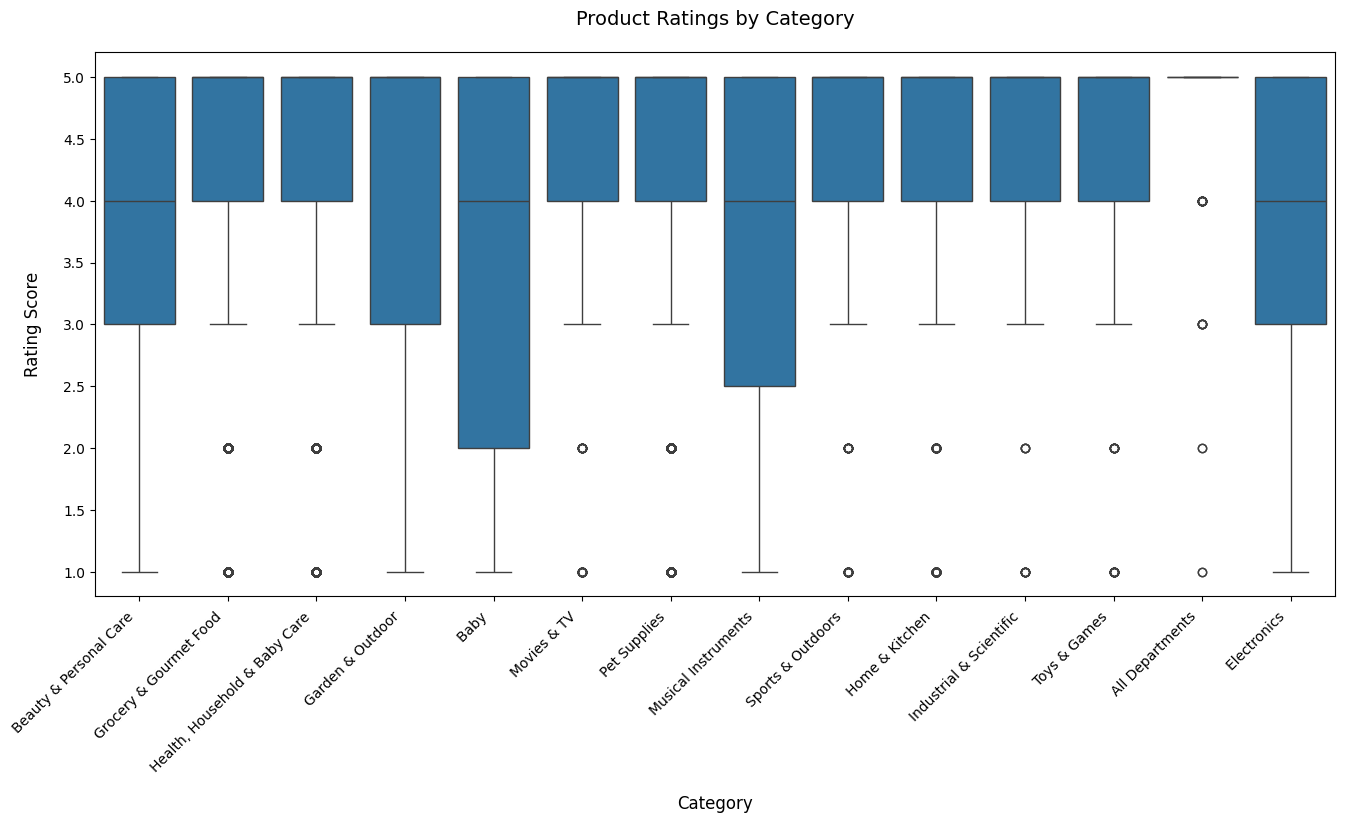

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt
import ast

merged_df = pd.merge(new_df, df, on='ProductId', how='left')

plt.figure(figsize=(16, 8))

sns.boxplot(data=merged_df, x='Category', y='Score')

plt.title('Product Ratings by Category', pad=20, fontsize=14)
plt.xlabel('Category', labelpad=15, fontsize=12)
plt.ylabel('Rating Score', labelpad=15, fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.subplots_adjust(bottom=0.2)

plt.show()

In [56]:
review_counts = merged_df.groupby('Category').size()
print("\nNumber of reviews per category:")
print(review_counts)


Number of reviews per category:
Category
All Departments                      173
Baby                                 658
Beauty & Personal Care              2343
Electronics                          246
Garden & Outdoor                    2606
Grocery & Gourmet Food            107114
Health, Household & Baby Care       6888
Home & Kitchen                      1262
Industrial & Scientific               93
Movies & TV                          573
Musical Instruments                   87
Pet Supplies                       19542
Sports & Outdoors                    264
Toys & Games                         177
dtype: int64


In [46]:
!pip install numpy

In [58]:
import openai
import os

client = openai.OpenAI(api_key=process.env.OPENAI_API_KEY)

prompt = """
Please identify whether this review is positive.
Respond with 'True' or 'False', with no extra information.
"""

def label_text(text):
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "system", "content": prompt},
            {"role": "user", "content": f"Please label the following text: '{text}'"}
        ]
    )
    return response.choices[0].message.content


vals = []
for index, row in df.iterrows():
    text = row['Text']
    label = label_text(text)
    vals.append(label)
df.at['Positive'] = label

KeyboardInterrupt: 

In [59]:
lengths = []
for index, row in df.iterrows():
    lengths.append(len(row['Text']))
df['Length'] = lengths

KeyboardInterrupt: 

In [60]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

positive_counts = df['Positive'].value_counts()
print(positive_counts)

df['helpfulness_ratio'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
df['helpfulness_ratio'] = df['helpfulness_ratio'].replace([np.inf, -np.inf], 0)
df_clean = df.dropna(subset=['Positive'])

plt.figure(figsize=(10, 6))
sns.boxplot(x='Positive', y='helpfulness_ratio', data=df_clean)
plt.title('Review Helpfulness Distribution by Sentiment')
plt.xlabel('Positive Review')
plt.ylabel('Helpfulness Ratio')

plt.show()

KeyError: 'Positive'

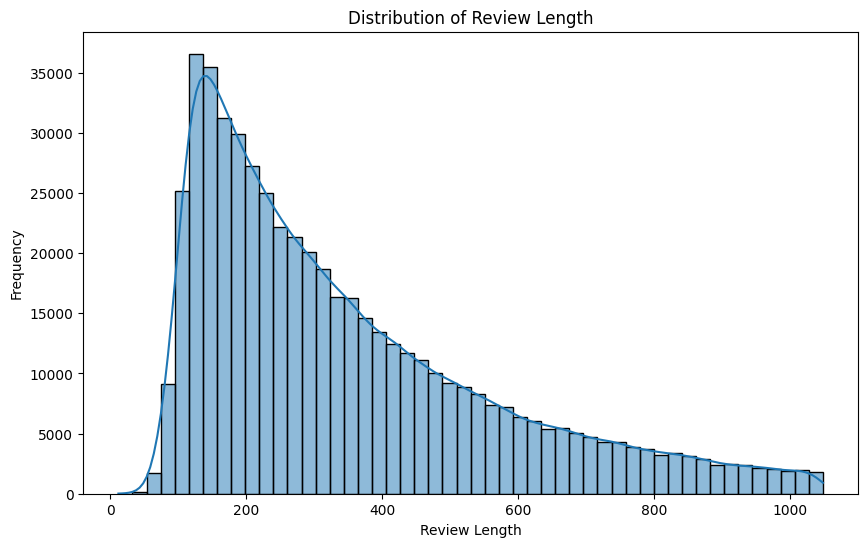

In [ ]:
Q1 = df['Length'].quantile(0.25)
Q3 = df['Length'].quantile(0.75)
IQR = Q3 - Q1

df_filtered = df[(df['Length'] >= Q1 - 1.5 * IQR) & (df['Length'] <= Q3 + 1.5 * IQR)]

plt.figure(figsize=(12, 6))
sns.histplot(df_filtered['Length'], bins=50, kde=True)
plt.title('Distribution of Review Length')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.show()


In [ ]:
prompt = """
Please rate the depth of this response from 1-5 where 5 is the very detailed review providing novel feedback and 1 is a surface level review.
Respond with a single number, with no extra information.
"""

def label_text(text):
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "system", "content": prompt},
            {"role": "user", "content": f"Please provide a depth rating on the following text: '{text}'"}
        ]
    )
    return response.choices[0].message.content


depths = []
for index, row in df.iterrows():
    text = row['Text']
    label = label_text(text)
    depths.append(label)

df.at['Depth'] = depths

0: 1
1: 2
2: 2
3: 2
4: 2
5: 2
6: 1
7: 1
8: 1
9: 2
10: 1
11: 2
12: 3
13: 1
14: 1
15: 1
16: 2
17: 1
18: 1
19: 2
20: 2
21: 2
22: 1
23: 1
24: 1
25: 2
26: 1
27: 2
28: 1
29: 2
30: 2
31: 1
32: 4
33: 3
34: 1
35: 2
36: 1
37: 2
38: 2
39: 2
40: 2
41: 3
42: 2
43: 2
44: 2
45: 2
46: 2
47: 2
48: 2
49: 2
50: 1
51: 2
52: 2
53: 3
54: 3
55: 2
56: 1
57: 1
58: 2
59: 1
60: 2
61: 2
62: 1
63: 3
64: 2
65: 2
66: 2
67: 3
68: 2
69: 1
70: 2
71: 2
72: 2
73: 4
74: 1
75: 2
76: 2
77: 2
78: 2
79: 2
80: 1
81: 1
82: 4
83: 3
84: 3
85: 2
86: 2
87: 2
88: 2
89: 2
90: 1
91: 1
92: 1
93: 2
94: 1
95: 2
96: 2
97: 2
98: 2
99: 2
100: 2
101: 2
102: 2
103: 2
104: 2
105: 1
106: 1
107: 2
108: 1
109: 1
110: 2
111: 1
112: 4
113: 2
114: 1
115: 1
116: 2
117: 1
118: 4
119: 2
120: 3
121: 3
122: 2
123: 2
124: 2
125: 3
126: 2
127: 2
128: 1
129: 1
130: 1
131: 3
132: 2
133: 2
134: 1
135: 2
136: 1
137: 1
138: 2
139: 3
140: 3
141: 2
142: 2
143: 2
144: 3
145: 2
146: 3
147: 2
148: 3
149: 1
150: 2
151: 1
152: 2
153: 2
154: 2
155: 2
156: 2
157: 2
158:

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(12, 8))
sns.violinplot(x='Positive', y='Depth', data=df)
plt.title('Review Depth by Sentiment')
plt.xlabel('Positive Review')
plt.ylabel('Depth')
plt.show()

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.6 MB/s eta 0:00:00


In [ ]:
!pip install shap

ERROR: Operation cancelled by user


In [49]:
import pandas as pd
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
import shap

df_clean = df.dropna(subset=['Positive', 'Depth'])

df_clean = df_clean.drop(columns=['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time', 'Summary', 'Depth', 'Text'])

df_clean['helpfulness_ratio'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
df_clean = df_clean.replace([np.inf, -np.inf], np.nan).dropna(subset=['helpfulness_ratio'])

categorical_df = df_clean.select_dtypes(include=['object'])
numerical_df = df_clean.select_dtypes(include=['number'])

categorical_features = list(categorical_df.columns)

categorical_df = categorical_df.fillna("NA")

numerical_df = numerical_df.fillna(numerical_df.median())

df_clean = pd.concat([categorical_df, numerical_df], axis=1)

X = df_clean.drop(columns=['Length'])
y = df_clean['Length']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

catboost_model = CatBoostRegressor(iterations=100, learning_rate=0.1, depth=6, verbose=0)

catboost_model.fit(X_train, y_train, eval_set=(X_test, y_test), plot=True, cat_features=categorical_features)

y_pred = catboost_model.predict(X_test)

explainer = shap.Explainer(catboost_model)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test)

ModuleNotFoundError: No module named 'catboost'

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, r2_score, ConfusionMatrixDisplay

df_clean2 = df.dropna(subset=['Positive', 'Depth'])

df_clean2 = df_clean.drop(columns=['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time', 'Summary', 'Depth', 'Text'])

df_clean2['helpfulness_ratio'] = my_df['HelpfulnessNumerator'] / my_df['HelpfulnessDenominator']
df_clean2.replace([np.inf, -np.inf], np.nan, inplace=True)
df_clean2.dropna(subset=['helpfulness_ratio'], inplace=True)

df_clean2 = pd.get_dummies(df_clean)

X = df_clean2.drop(columns=['Positive'])
y = df_clean2['Positive'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train, y_train)

y_pred = logistic_model.predict(X_test)

print("Accuracy Score: ", accuracy_score(y_test, y_pred))
print("Model Results:\n", classification_report(y_test, y_pred))

Accuracy Score:  0.9761904761904762
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.94      0.97        48
           1       0.96      1.00      0.98        78

    accuracy                           0.98       126
   macro avg       0.98      0.97      0.97       126
weighted avg       0.98      0.98      0.98       126

